# Task 3
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from matplotlib.colors import ListedColormap
sns.set_palette('viridis')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data
In this section we read the data in after the preprocessing from the preprocessing notebook

In [2]:
df = pd.read_pickle('../data/preprocessed/accepted_df_preprocessed.pkl')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 94)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0
5,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0


# Encode Features from categorical to numerical

In [3]:
# Preview categorical data
print(df.dtypes.value_counts())
# Get categorical columns names
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# change format
for col in cat_columns:
    df[col] = df[col].astype('category')

float64    87
object      6
int64       1
dtype: int64


In [4]:
# Label Encoding
df_ec = df.copy()
for col in cat_columns:
    df_ec[col] = df[col].cat.codes
# check
df_ec.dtypes.value_counts()

float64    87
int8        6
int64       1
dtype: int64

In [5]:
# One-Hot-Encoding
df_hoe = pd.get_dummies(data=df, columns=cat_columns, drop_first=True)
# check
df_hoe.dtypes.value_counts()

float64    87
uint8      49
int64       1
dtype: int64

In [6]:
# Binary Encoding
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=cat_columns)
df_binary = encoder.fit_transform(df)
# check
df_binary.dtypes.value_counts()

float64    87
int64      19
dtype: int64

In [7]:
# Convert all values to float
df_ec = df_ec.astype(float)
df_binary = df_binary.astype(float)
df_hoe = df_hoe.astype(float)

# Create Balanced Data Set via Downsampling

0.0    1076751
1.0     268559
Name: loan_status, dtype: int64
(1345310, 106)


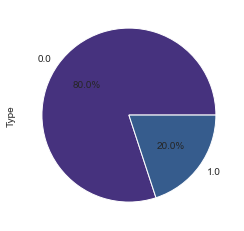

In [8]:
print(df_binary.loan_status.value_counts())
print(df_binary.shape)
df_binary.groupby('loan_status').size().plot(kind='pie', y = "loan_status", label = "Type", autopct='%1.1f%%')

In [9]:
# Take only fraction of the data
df_binary_sample = df_binary.sample(frac = 0.05)
print(df_binary_sample.shape)
print(df_binary_sample.loan_status.value_counts())

(67266, 106)
0.0    53878
1.0    13388
Name: loan_status, dtype: int64


0.0    17404
1.0    13388
Name: loan_status, dtype: int64


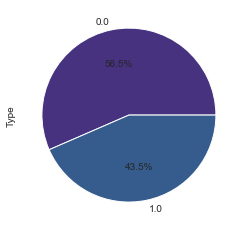

In [10]:
# Downsampling
loan_status_0 = df_binary_sample[df_binary_sample["loan_status"] == 0.0]
loan_status_1  = df_binary_sample[df_binary_sample["loan_status"] == 1.0]

loan_status_0_downsample = resample(loan_status_0,
             replace=True,
             n_samples=round(1.3*len(loan_status_1)),
             random_state=42)

df_binary_downsampled = pd.concat([loan_status_0_downsample, loan_status_1])

print(df_binary_downsampled["loan_status"].value_counts())
df_binary_downsampled.groupby('loan_status').size().plot(kind='pie', y = "loan_status", label = "Type", autopct='%1.1f%%')

In [11]:
# Fill NaNs with Median
df_binary_downsampled = df_binary_downsampled.fillna(df_binary_downsampled.median())
# Preview
df_binary_downsampled.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term_0,term_1,int_rate,installment,grade_0,grade_1,grade_2,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
1920849,5600.0,5600.0,5600.0,0.0,1.0,8.90,177.82,1.0,0.0,0.0,...,0.0,2.0,97.8,0.0,0.0,0.0,104152.0,32734.0,4100.0,31899.0
1316988,8000.0,8000.0,8000.0,0.0,1.0,12.99,269.52,0.0,1.0,0.0,...,0.0,2.0,100.0,85.7,0.0,0.0,173100.0,12959.0,12700.0,0.0
311720,1800.0,1800.0,1800.0,0.0,1.0,17.57,64.69,1.0,1.0,0.0,...,0.0,4.0,100.0,60.0,0.0,0.0,21100.0,8260.0,5400.0,4000.0
1659034,12200.0,12200.0,11900.0,0.0,1.0,11.49,402.25,0.0,1.0,0.0,...,0.0,9.0,100.0,0.0,0.0,0.0,42419.0,17370.0,14700.0,23091.0
368460,5000.0,5000.0,5000.0,0.0,1.0,6.39,153.00,1.0,0.0,0.0,...,0.0,0.0,100.0,0.0,0.0,0.0,47000.0,21259.0,18400.0,15000.0


# Data Split
In this section we split the data into a training and test set. The corresponding model is then trained on the training set and tested on the test set.

In [12]:
# Fraction of test data
TEST_SIZE = 0.3

X = df_binary_downsampled.drop("loan_status", axis=1)
y = df_binary_downsampled["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (21554, 105)
Shape of X_test: (9238, 105)
Shape of y_train: (21554,)
Shape of y_test: (9238,)


# Scaling

In [13]:
# Init object
scaler = StandardScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
# Scale X_test
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Preview X_train_scaled
X_train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,-0.598601,-0.597949,-0.595183,-0.631213,0.631213,-1.230866,-0.566636,1.201683,-0.945969,-0.869276,...,-0.173239,-0.684070,0.235964,-0.386459,-0.364705,-0.145357,0.119817,-0.820933,-0.350549,-1.009307
1,-0.781395,-0.780774,-0.777968,-0.631213,0.631213,0.001535,-0.670510,-0.832166,-0.945969,1.150383,...,-0.173239,0.404362,-0.020023,0.085382,7.656563,-0.145357,-0.897187,-0.827000,-0.922561,-0.736293
2,0.600988,0.601834,0.604341,1.584251,-1.584251,-0.676386,-0.056551,-0.832166,1.057117,-0.869276,...,-0.173239,-0.139854,0.666488,-0.762237,-0.364705,-0.145357,0.985969,-0.103905,1.380282,0.387006
3,1.743452,1.744485,1.746745,-0.631213,0.631213,-0.973863,1.942144,-0.832166,1.057117,-0.869276,...,-0.173239,-0.684070,0.177785,-0.386459,-0.364705,-0.145357,-0.725069,-0.557153,-0.616831,-1.009307
4,1.971945,1.973015,1.975226,1.584251,-1.584251,0.726001,1.366477,1.201683,1.057117,-0.869276,...,-0.173239,0.404362,0.666488,1.498082,-0.364705,-0.145357,-0.759825,-0.386643,-0.730247,-0.214870


---
# Task 3: Logistic Regression In Sample

In [14]:
# Fit Model
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)

# Predict In Sample
y_pred = lr.predict(X_train_scaled)

## Test Model

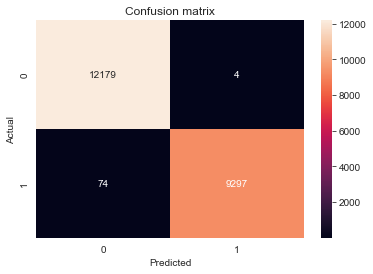

________________________________________________________________________________
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     12183
         1.0       1.00      0.99      1.00      9371

    accuracy                           1.00     21554
   macro avg       1.00      1.00      1.00     21554
weighted avg       1.00      1.00      1.00     21554

Information:
Precision: Percentage of correct positive predictions relative to total positive predictions
Recall: Percentage of correct positive predictions relative to total actual positives.
F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.
________________________________________________________________________________


In [15]:
# Plot Confusion matrics
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(80 * "_")
print(classification_report(y_true=y_train, y_pred=y_pred))
print("Information:")
print("Precision: Percentage of correct positive predictions relative to total positive predictions")
print("Recall: Percentage of correct positive predictions relative to total actual positives.")
print("F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.")
print(80 * "_")

---
# Task 4

Comparing
* logistic regression,
* classification tree,
* random forest,
* bagging,
* support vector machine (with two kernel functions),
* and neural network
for default prediction based on the out-of-sample performance measures (at least three different measures).

In [16]:
# Ale: Ist bereits skaliert (siehe oben bei Task 3)
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)

In [17]:
%%time
models = []

models.append(("LogisticRegression",LogisticRegression(fit_intercept=True, max_iter=5000, solver="saga")))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("BaggingCLF",BaggingClassifier()))
models.append(("SVC",SVC(kernel='rbf')))
models.append(("SVC",SVC(kernel="linear")))
models.append(("NeuronalNetwork", MLPClassifier(alpha=1, max_iter=1000)))

results = []
names = []
for name,model in tqdm(models):
    result = cross_val_score(model, X_train_scaled, y_train,  cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

100%|██████████| 7/7 [03:14<00:00, 27.76s/it] 

LogisticRegression 0.9924840065735397
DecisionTree 0.9857102486569035
RandomForest 0.990674584723701
BaggingCLF 0.9902570288158069
SVC 0.9790294703712831
SVC 0.9973555050812678
NeuronalNetwork 0.985803163709762
CPU times: user 3min 11s, sys: 4.61 s, total: 3min 16s
Wall time: 3min 14s


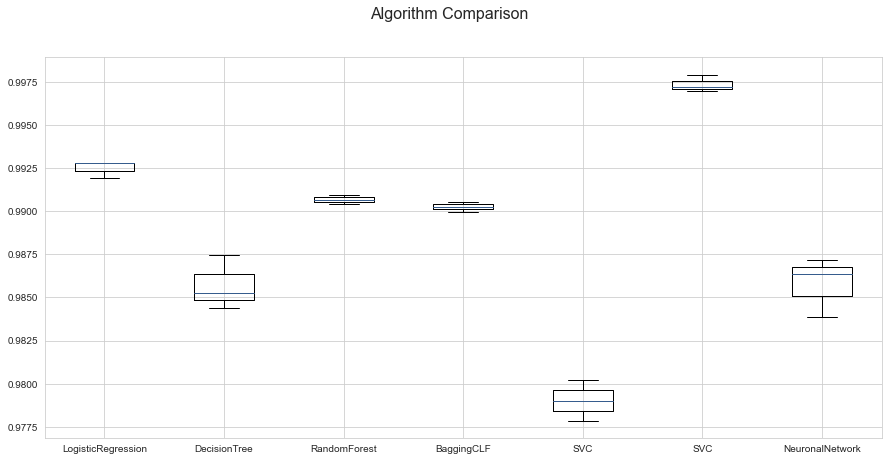

In [18]:
#results_df = pd.DataFrame({"Algorithm": names, "Score": results})

# boxplot algorithm comparison
fig = plt.figure(figsize=(15,7))
fig.suptitle('Algorithm Comparison', size=16)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# data point plot - total, train, test
figure, ax = plt.subplots(3, len(models))

cm_bright = ListedColormap(["#FF0000", "#0000FF"])
#x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
#y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

for ax, model in zip(ax.flatten(), models):
    
    name = model[0]
    clf = model[1]
    
    clf.fit(X_train_scaled, y_train)
    score = clf.score(X_test_scaled, y_test)

    # Plot the training points
    ax.scatter(
        X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    #ax.set_xlim(x_min, x_max)
    #ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f"{name}")
   # ax.text(
   #     x_max - 0.3,
   #     y_min + 0.3,
   #     ("%.2f" % score).lstrip("0"),
   #     size=15,
   #     horizontalalignment="right",
   #)

plt.tight_layout()
plt.show()